# 01 Getting started: types of domain

JellyBamm allows you to run a PyBaMM simulation coupled with a network representation of a jelly roll domain which allows greater spatial resolution of the battery parameters and a more accurate representation of electrical and thermal transport.

There are 3 ways to generate the domain for a JellyBaMM simulation:
- Create a 1D network representing a single layer
- Create a 2D idealised spiral
- Read an image of the jellyroll and extract the topology from there

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import ecm
import liionpack as lp
import pybamm
import numpy as np

In [2]:
wrk = op.Workspace()
wrk.clear()

## 1D network

In this first example we will create a 1D network topology defining the number of units and the spacing between the units. This is useful for testing purposes but may also be used to simulate single layer pouch cells. The code automatically extends the network by one unit length on either side of the battery segments to add tab positions. We must also provide the relative node positions of each positive and negative terminal.

In [3]:
Nunit = 10
spacing = 0.1
pos_tabs = [-1]
neg_tabs = [0]
project, arc_edges = ecm.make_1D_net(Nunit, spacing, pos_tabs, neg_tabs)

This funcion returns an OpenPNM project which contains several objects that can be inspected below.

In [4]:
project

[net : <openpnm.network.Cubic at 0x1041a80b0>,
 phase_01 : <openpnm.phase.Phase at 0x10412bef0>]

The network defines the topology and positions of the nodes as well as connections between nodes. Blue resistors represent the negative current collector electrical and thermal connections and red resistors represent the positive ones. Green nodes represent thermal boundaries. Black connections between opposing current collectors represent the battery segments and these will contain voltage sources and internal resistors that are determined by electrochemical simulation using PyBaMM and liionpack.

In [5]:
net = project.network
net

net : <openpnm.network.Cubic at 0x1041a80b0>

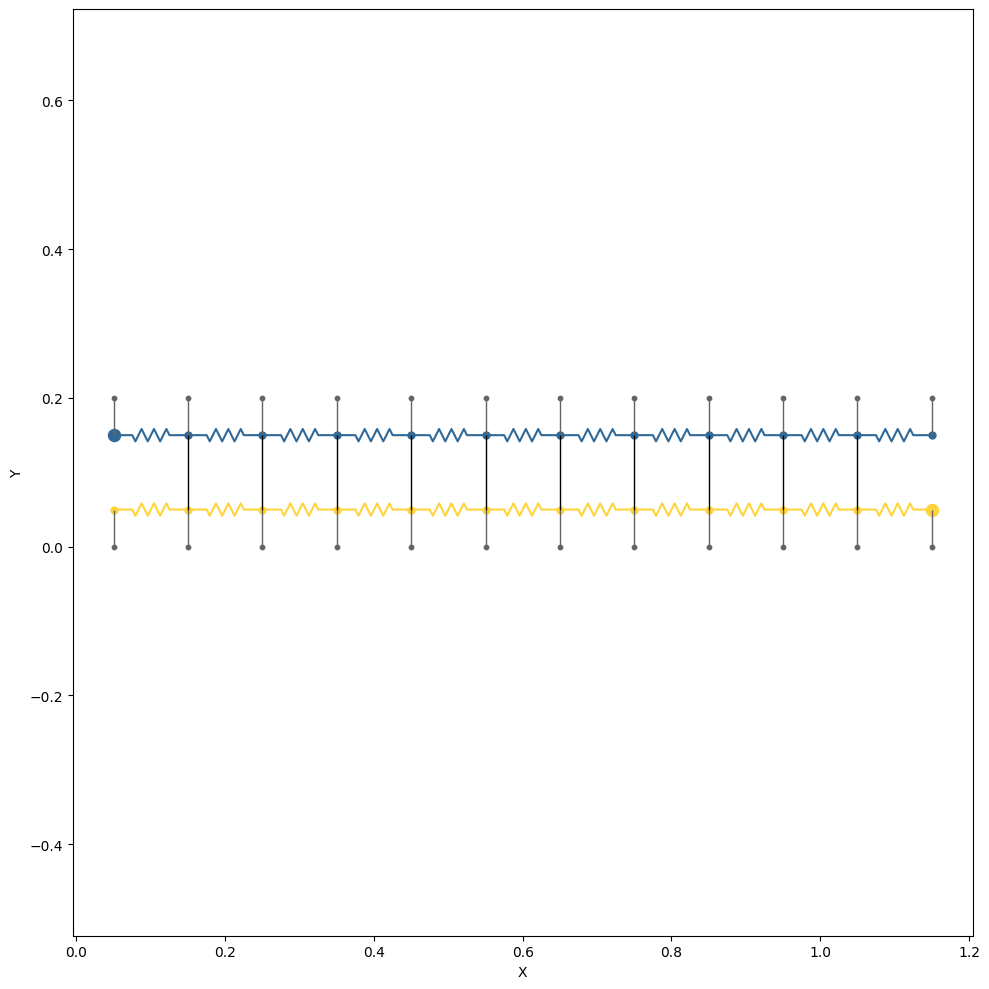

In [6]:
ecm.plot_topology(net)

In [7]:
net.labels()

['pore.all',
 'pore.free_stream',
 'pore.neg_cc',
 'pore.neg_tab',
 'pore.pos_cc',
 'pore.pos_tab',
 'pore.xmax',
 'pore.xmin',
 'pore.ymax',
 'pore.ymin',
 'throat.all',
 'throat.back_boundary',
 'throat.free_stream',
 'throat.front_boundary',
 'throat.neg_cc',
 'throat.pos_cc',
 'throat.spm_neg_inner',
 'throat.spm_resistor']

OpenPNM is a pore network simulator originally designed for solving percolation and transport problems on network representations of porous materials. However, the package has many useful generic functions for solving any linear equation on a network which can generally be described by nodes and edges. The convention in the earth science is to refer to nodes as pores and edges as throats which connect the pores. Above we see that the network has several labels which contain boolean values for each type of object in the network. `pore.all` and `throat.all` have True for every element and are used to determine the length of any subsequent array containing pore or throat information. The quick way to access the number of pores and throats is as follows:

In [8]:
net.Np

48

This number is formed of (10 battery segments + 2 terminal segments) * (positive + negative + 2 * thermal boundary)

In [9]:
np.allclose(net.num_pores('pos_cc'), net.num_pores('neg_cc'), net.num_pores('free_stream')/2, 12)

True

In [10]:
net.Nt

56

## 2D idealised spiral

The main method for generating the simulation domains is the 2D spiral network which takes the following parameters:
- Number of layers
- Angle between nodes in each layer
- Spacing of layers
- Inner radius of spiral (x-position of first node)
- Positive and Negative relative tab positions
- Tesla tabs (boolean) which overides the relative tab positions

In [11]:
wrk.clear()
Nlayers = 5
dtheta = 10
spacing = 195e-6
inner_r = 10 * spacing
pos_tabs = [-1]
neg_tabs = [0]
length_3d = 0.08
tesla_tabs = False

In [12]:
project, arc_edges = ecm.make_spiral_net(Nlayers,
                                         dtheta,
                                         spacing,
                                         inner_r,
                                         pos_tabs,
                                         neg_tabs,
                                         length_3d,
                                         tesla_tabs)

[12:28:53] WARNING  Converting throat.conns to be upper triangular                                  ]8;id=509082;file:///Users/tleo/micromamba/envs/pnm/lib/python3.11/site-packages/openpnm/network/_network.py\_network.py]8;;\:]8;id=403806;file:///Users/tleo/micromamba/envs/pnm/lib/python3.11/site-packages/openpnm/network/_network.py#126\126]8;;\

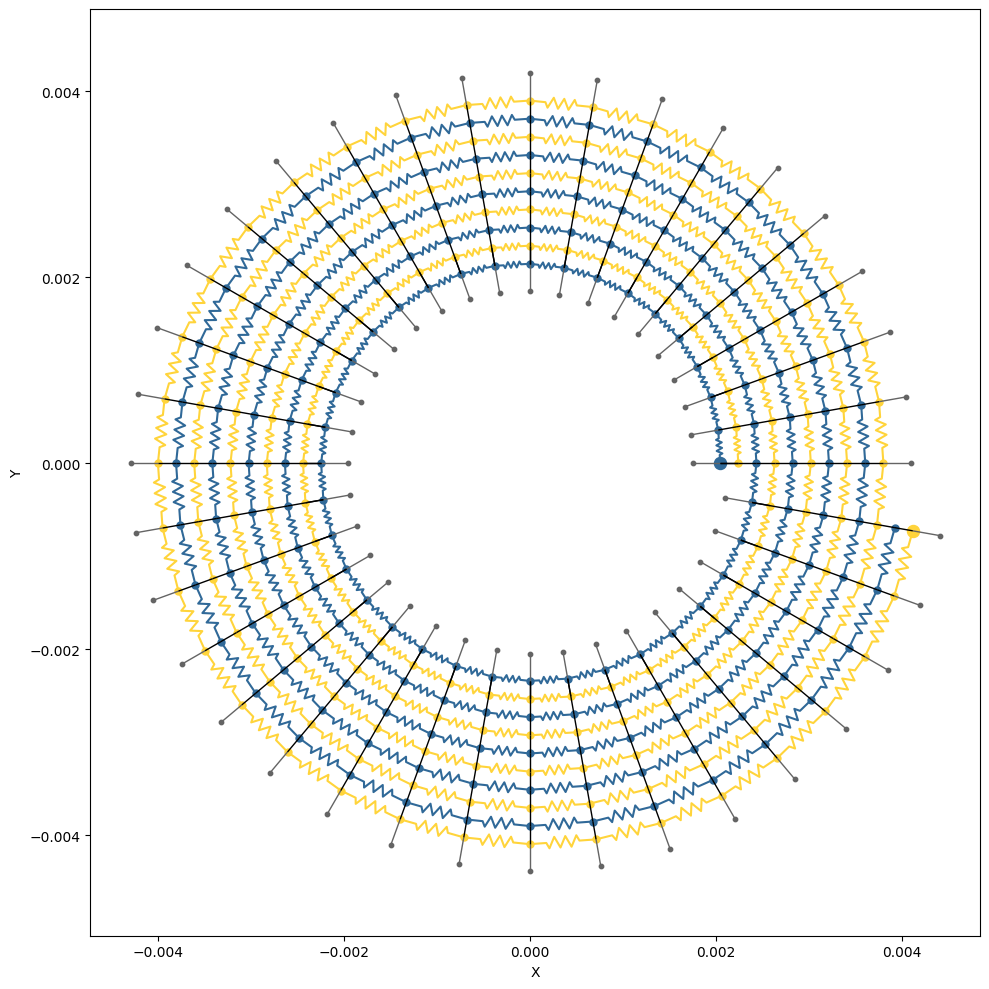

In [13]:
net = project.network
ecm.plot_topology(net)

## Extract from image

The following network is loaded from a `.pnm` file that was extracted from an image. The next notebook will cover how to do this extraction.

In [14]:
wrk.clear()
ecm.INPUT_DIR

'/Users/tleo/Code/Ionworks/PNM/pybamm_pnm/ecm/input'

In [15]:
import os
os.listdir(ecm.INPUT_DIR)

['im_soft.npz',
 'MJ141-mid-top_m.pnm',
 'MJ141-mid-top_m_cc_new.pnm',
 'MJ141-mid-top_m_cc_ecm.pnm',
 'im_spm_map_46800.npz',
 '46800.pnm',
 '__init__.py',
 'im_spm_map.npz',
 'MJ141-mid-top_m_cc.pnm',
 'spider_net.pnm',
 'MJ141-mid-top_m_cc_new_ps11.pnm',
 '0800.tiff',
 'cc_im.npz']

In [16]:
tomo_pnm = "spider_net.pnm"
dtheta = 10
spacing = 195e-6
length_3d = 0.08
pos_tabs = [-1]
neg_tabs = [0]

In [17]:
project, arc_edges = ecm.make_tomo_net(tomo_pnm, dtheta, spacing,
                                       length_3d, pos_tabs, neg_tabs)

UnpicklingError: invalid load key, 'H'.

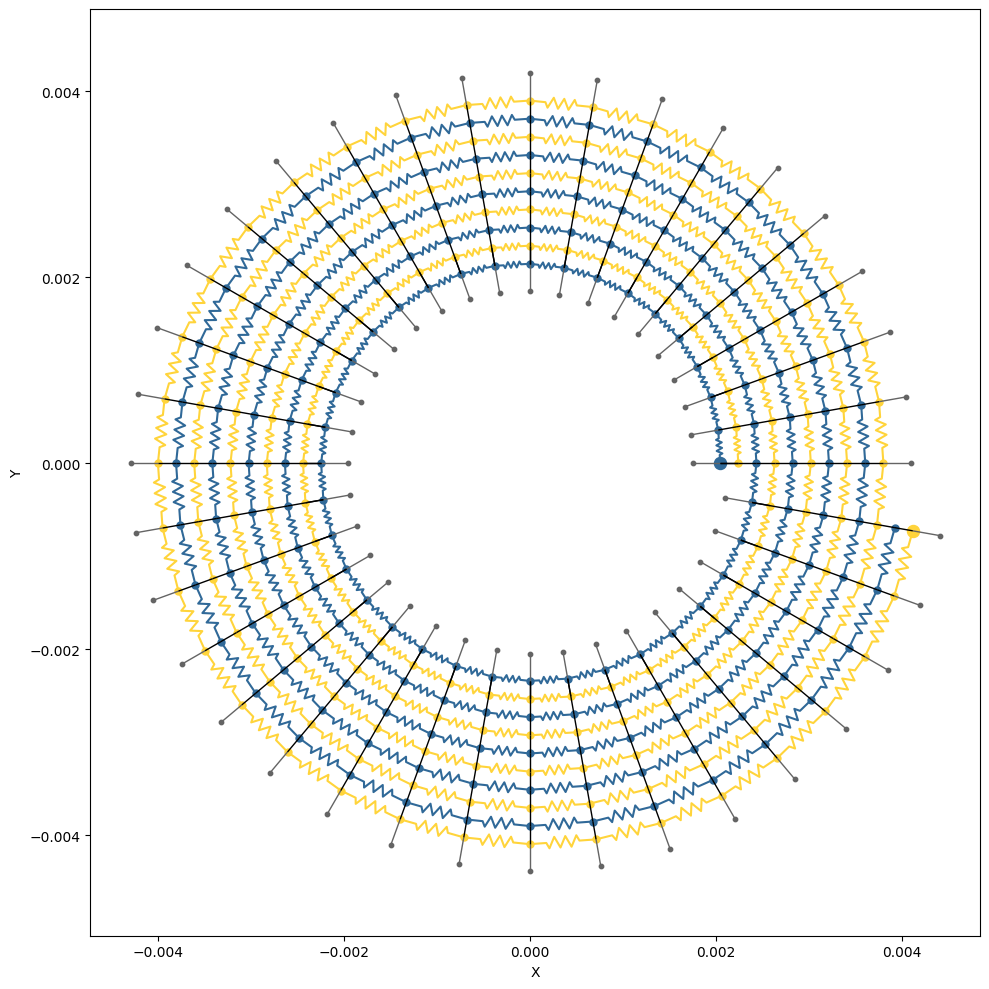

In [18]:
net = project.network
ecm.plot_topology(net)